## Red Neuronal
### Ignacio Castro
### Sergio Pacheco

## 1. Preparación del Dataset para extraer la categoría de las noticias

In [51]:
#Todo este bloque esta dedicado a cargar el dataset en formato facil de trabajar con CNN.

import pandas as pd
from pandasql import sqldf
df = pd.read_csv('datatotal.csv')
print(df.shape)
df.head(4)
# Columnas importantes
ndata = df[['text', 'target_topic']]
data_final = ndata.groupby('target_topic').sample(n=157, random_state=2)
data_final.target_topic.value_counts()
ndata = data_final

# Target topics
q="""SELECT target_topic FROM df GROUP BY target_topic"""
topics=sqldf(q)
topics = topics['target_topic'].to_numpy()
print(topics)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def process_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    
    stop_words = set(stopwords.words('spanish')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

ndata['text_parsed'] = ndata['text'].apply(process_text)

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
print(ndata.target_topic.value_counts())
CNNdata = ndata[['text_parsed', 'target_topic']]
CNNdata['topic_num']= label_encoder.fit_transform(ndata['target_topic'])
#CNNdata = CNNdata[['text_parsed', 'topic_num']]
print("-------")
print(CNNdata.topic_num.value_counts())

from pandasql import sqldf
import numpy as np
from sklearn.model_selection import train_test_split

tdf=CNNdata.loc[CNNdata['topic_num'] == 0]
valid, test, train = np.split(tdf, [int(.15*len(tdf)), int(.3*len(tdf))])
for i in range(1,10):
    tdf=CNNdata.loc[CNNdata['topic_num'] == i]
    tvalid, ttest, ttrain = np.split(tdf, [int(.15*len(tdf)), int(.3*len(tdf))])
    valid=pd.concat([valid, tvalid])
    test=pd.concat([test, ttest])
    train=pd.concat([train, ttrain])

print(CNNdata.shape)
print(train.shape)
print(valid.shape)
print(test.shape)
print(train.topic_num.value_counts())

(21252, 12)
['Catástrofes y Accidentes' 'Ciencias y Tecnologia'
 'Crimen, delitos y justicia' 'Cultura y Artes' 'Deporte' 'Ecologia'
 'Economia' 'Mundo' 'Politica y Conflictos' 'Salud']
Politica y Conflictos         157
Crimen, delitos y justicia    157
Cultura y Artes               157
Ciencias y Tecnologia         157
Deporte                       157
Mundo                         157
Catástrofes y Accidentes      157
Ecologia                      157
Salud                         157
Economia                      157
Name: target_topic, dtype: int64
-------
9    157
8    157
7    157
6    157
5    157
4    157
3    157
2    157
1    157
0    157
Name: topic_num, dtype: int64
(1570, 3)
(1100, 3)
(230, 3)
(240, 3)
9    110
8    110
7    110
6    110
5    110
4    110
3    110
2    110
1    110
0    110
Name: topic_num, dtype: int64


In [52]:
CNNdata.head(1000)

,text_parsed,target_topic,topic_num
14886,investigación congreso unidos responsabilizó b...,Catástrofes y Accidentes,0
19882,así chile pasará navidad año nuevo verano 2021...,Catástrofes y Accidentes,0
668,historial navegación persona puede decirnos mu...,Catástrofes y Accidentes,0
7946,dos mil accidentes involucrado año ciclistas s...,Catástrofes y Accidentes,0
14455,josé huirimilla identificada persona murió tra...,Catástrofes y Accidentes,0
...,...,...,...
17163,mayor disminución precios arriendo departament...,Economia,6
17021,tras siete meses emergencia sanitaria cara ver...,Economia,6
19894,miembros organización países exportadores petr...,Economia,6
15582,santiago diario oficial publicó hoy decreto mi...,Economia,6


In [53]:
#Dividir Dataset equilibradamente
valid = valid.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
train = train.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
test = test.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
valid = valid[['body', 'category']]
test = test[['body', 'category']]
train = train[['body', 'category']]

In [54]:
#Guardar datos en archivos
train.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

## 2. Clasificar textos según su categoria temática con una red convolucional

### 2.1 Leer el dataset

In [55]:
import torch
import spacy
import random
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

In [56]:
#REvisamos version de torch.
import torch
print(torch.__version__) #1.7.0

1.10.0


In [57]:
#Cargamos tokenizados para español.
spacy_es = spacy.load('es_core_news_sm')

In [58]:
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]

In [59]:
#Revusamos todas las versiones.
print(torch.__version__,spacy.__version__,torchtext.__version__)

1.10.0 3.2.0 0.11.0


In [60]:
TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
CATEGORY = data.LabelField()

In [61]:
#Definimos campos
fields = [('body', TEXT),('category', CATEGORY)]

In [62]:
#Se leen los CSV para tokenizarlos con Torch
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [63]:
BATCH_SIZE = 32

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=lambda x:len(x.category),
    sort_within_batch=False)

cuda


### 2.2 Crear la arquitectura CNN

In [64]:
#Vector se puede descargar con
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [65]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data, vectors=vec, max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)

CATEGORY.build_vocab(train_data)

In [66]:
#Ver numero asociado a cada categoria
print(CATEGORY.vocab.stoi)

defaultdict(None, {'Catástrofes y Accidentes': 0, 'Ciencias y Tecnologia': 1, 'Crimen, delitos y justicia': 2, 'Cultura y Artes': 3, 'Deporte': 4, 'Ecologia': 5, 'Economia': 6, 'Mundo': 7, 'Politica y Conflictos': 8, 'Salud': 9})


In [67]:
#Difinir estructura CNN
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
    
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        embedded = self.embedding(text)
                        
        embedded = embedded.unsqueeze(1)
                
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
                    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        return self.fc(cat)

In [68]:
#Parametros modelos
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [1,2,3,4]
OUTPUT_DIM = len(CATEGORY.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [69]:
#Verificar numero topicos/dimension salida
OUTPUT_DIM

10

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,145,310 trainable parameters


In [71]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

### 2.3 Funciones para optimizar el modelo

In [72]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [73]:
#Definimos train
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.body)
                
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [74]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 2.4 Funciones para evaluar el modelo

In [75]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.cuda.FloatTensor([y.shape[0]])

In [76]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.body)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)




### 2.5 Optimización del modelo

In [77]:
print("inicio optimización")

N_EPOCHS = 5 #5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        name = './tematic-model-CNN'+'_ep'+str(epoch+1)+'.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



inicio optimización
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 2.002 | Train Acc: 33.78%
	 Val. Loss: 1.591 |  Val. Acc: 64.71%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.176 | Train Acc: 70.86%
	 Val. Loss: 1.100 |  Val. Acc: 67.97%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.721 | Train Acc: 82.80%
	 Val. Loss: 0.940 |  Val. Acc: 68.75%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.493 | Train Acc: 87.32%
	 Val. Loss: 0.710 |  Val. Acc: 78.26%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.347 | Train Acc: 91.55%
	 Val. Loss: 0.678 |  Val. Acc: 78.91%


### 2.6 Evaluación del modelo

In [79]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [80]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [81]:
#Cargamos mejor modelo
name = './tematic-model-CNN'+'_ep'+str(5)+'.pt'
best_model.load_state_dict(torch.load(name, map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [82]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.715 | Test Acc: 80.86%


In [83]:
prediction_test = []
labels_test=[]
for batch in test_iterator:
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.body.cpu()).squeeze(1)
    #print(torch.sigmoid(predictions))
    rounded_preds = torch.round(torch.sigmoid(predictions))
    prediction_test.append(rounded_preds.detach().numpy())
    #print(prediction_test)
    

y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

## 2.7 Hacer predicciones con el modelo

In [85]:
def predict_class(model, sentence, min_len = 4):

    tokenized = [tok.text for tok in spacy_es.tokenizer(sentence)]
    
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    
    print(indexed)
    #indexed2 = [[0, 0, 1382, 0, 102, 72, 0, 297, 0],[0, 0, 1382, 0, 102, 72, 0, 297, 0]]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [86]:
from torchtext import data

pred_class = predict_class(model, "Futbol, pelota golazo de sanchez")
print('Predicted class is: ', pred_class)
#print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

[0, 0, 1941, 5219, 0, 0]
Predicted class is:  4


In [87]:
# Predicting with a test dataset

preds = torch.zeros(test.shape[0])
category = torch.zeros(test.shape[0])
n=0
for batch in test_iterator:
    predictions = model(batch.body)
    max_preds = predictions.argmax(axis=1)
    #print(batch.category.shape)
    #print(max_preds.shape[0])
    if(max_preds.shape[0] == 16):
        n= n + 16
        preds[n-16:n] = max_preds
        category[n-16:n] = batch.category
    else:
        n = n + 32
        preds[n-32:n] = max_preds
        category[n-32:n] = batch.category
    #print(predictions.shape)


Accuracy:  0.825
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        24
         1.0       0.92      0.50      0.65        24
         2.0       0.78      0.58      0.67        24
         3.0       0.86      1.00      0.92        24
         4.0       0.81      0.92      0.86        24
         5.0       0.81      0.92      0.86        24
         6.0       0.81      0.88      0.84        24
         7.0       0.77      0.71      0.74        24
         8.0       0.96      1.00      0.98        24
         9.0       0.68      0.79      0.73        24

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240



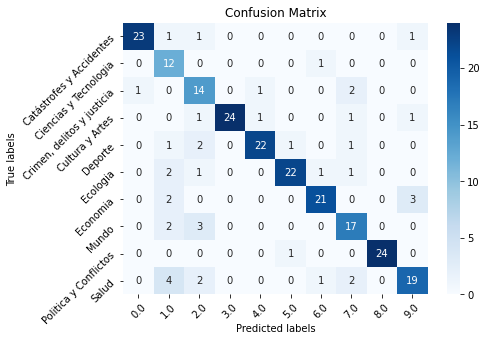

In [88]:
# Predicting with a test dataset
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#predicted = model1.predict(X_test)
print('Accuracy: ', accuracy_score(preds, category))
print(classification_report(category, preds))

confusion_matrix = pd.crosstab(preds, category)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

#ax.xaxis.set_ticklabels(topics); 
ax.yaxis.set_ticklabels(topics);

plt.xticks(rotation=45)
plt.yticks(rotation=45)
None

En general da buenos resultados, es el mejor de los modelos entrenados hasta ahora. Esto era de esperar por la potencia que suelen tener generalmente las redes neuronales. Sigue teniendo probelmas para para clasficar noticias ciencias y crimen. En crimen podría ser porque es uno de los temas en los que se tubo que recurrir a keywords, y en ciencias podrias ser porque tiene terminos comunes ocn otras noticias (pueden haber terminos cientificos en noticias de salud o tecnologia por ejemplo) lo que lleva a un alto recall. Finalmente es el mejor de los modelos obtenidos y con un dataset más grande podría quiza mejorar aun más-